<a href="https://colab.research.google.com/github/cgy11102/Car-Price-Prediction/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price Prediction

> Add blockquote



**Author:** Kyuhyeon Cho  
**Date:** 2025-11-05

**Purpose:** This notebook merges Kyuhyeon's polished presentation and Davis's statistical rigor. It contains thorough EDA, simple regressions, forward/backward selection, residual diagnostics, regularized models (Ridge/Lasso), a Random Forest benchmark, and a concise business-facing conclusion.

---

## Part 1: Problem Definition & Background

*(This section is added to address the 15-point rubric requirement.)*

### What is the problem?
The problem is to build a regression model that accurately predicts the Manufacturer's Suggested Retail Price (MSRP) of a vehicle based on its available features and attributes (e.g., Make, Model, Year, Engine HP, Vehicle Size, etc.). The goal is to create the best possible prediction model given the data at hand.

### Who might be interested in this problem and why?
Several groups would be interested in this model:
* **Consumers:** To verify they are getting a fair price on a new or used car.
* **Car Dealerships:** To inform their pricing strategies for trade-ins and sales inventory.
* **Insurance Companies:** To help determine the value of a vehicle when setting premiums or processing total-loss claims.
* **Manufacturers:** To analyze their own pricing structures relative to competitors and market trends.
* **Financial Institutions:** To assess the value of a vehicle when originating auto loans.

### What does the data look like?
The dataset (`car_pricing.csv`) contains over 10,000 records, where each row represents a specific car. The columns include a mix of numerical (e.g., `Engine HP`, `Year`, `highway MPG`) and categorical (e.g., `Make`, `Model`, `Driven_Wheels`) variables. The target variable is `MSRP`, which is a continuous numerical value, making this a regression task. A detailed exploratory data analysis (EDA) will be conducted to understand its features, distributions, and relationships.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Verify the current working directory
import os
print(f"Current working directory: {os.getcwd()}")

# change working directory based on your preference. Mine is the directory named 'Colab Notebooks' in MyDrive)
%cd /content/drive/MyDrive/Colab Notebooks

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content
/content/drive/MyDrive/Colab Notebooks
Current working directory: /content/drive/MyDrive/Colab Notebooks


## 1. Problem Definition & Background

**What is the problem?**  
Predict the manufacturer-suggested retail price (MSRP) of an automobile based on its features.

**Who might be interested?**  
- Car dealerships, pricing analysts, auto manufacturers, insurance companies, and consumers.
- These stakeholders all benefit from more accurate car price predictions for buying, selling, and valuing vehicles.

**What does the data look like?**  
- The dataset contains 11,914 cars and 16 features.  
- The target variable is `MSRP` (a continuous variable).


In [ ]:
# Load and preview the data
import pandas as pd

df = pd.read_csv('car_pricing.csv')
print("Shape:", df.shape)
df.head()


Shape: (11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


**Main Features:**
- Make, Model, Year, Engine HP, Engine Cylinders, Transmission Type, Driven_Wheels, Market Category, Vehicle Size, Vehicle Style, highway MPG, city MPG, Popularity, MSRP

**Missing values:**  
Check for columns with significant missing data and duplication.


In [ ]:
# Check missing values and duplicates
missing = df.isnull().sum()
duplicates = df.duplicated().sum()
print("Missing values:\n", missing)
print("Number of duplicate rows:", duplicates)


Missing values:
 Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64
Number of duplicate rows: 715


## 2. Data Cleaning

- Drop columns with excessive missingness, such as 'Market Category' (>30% missing).
- Impute missing values for Engine HP, Engine Cylinders, and Number of Doors using median values.
- Impute Engine Fuel Type using the mode per Model.
- Drop duplicate records.


In [ ]:
# Drop 'Market Category'
df = df.drop(columns=['Market Category'])

# Impute missing numeric values with median (by Model if possible, otherwise overall median)
for col in ['Engine HP', 'Engine Cylinders', 'Number of Doors']:
    df[col] = df.groupby('Model')[col].transform(lambda x: x.fillna(x.median()))
    df[col] = df[col].fillna(df[col].median())

# Impute missing categorical values (mode per Model)
df['Engine Fuel Type'] = df.groupby('Model')['Engine Fuel Type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))
df['Engine Fuel Type'] = df['Engine Fuel Type'].fillna('unknown')

# Drop duplicates
df = df.drop_duplicates()


## 3. Feature Conversion

- One-Hot Encode `Driven_Wheels`
- Ordinal Encode `Vehicle Size` ('Compact' < 'Midsize' < 'Large')
- Drop unnecessary categorical variables: Make, Model, Vehicle Style, Transmission Type, Engine Fuel Type


In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# One-hot encode Driven_Wheels
df = pd.get_dummies(df, columns=['Driven_Wheels'], prefix='Drive')

# Ordinal encode Vehicle Size
vehicle_size_order = ['Compact', 'Midsize', 'Large']
df['Vehicle Size Encoded'] = OrdinalEncoder(categories=[vehicle_size_order]).fit_transform(df[['Vehicle Size']])

# Drop unused categoricals
df = df.drop(columns=['Make', 'Model', 'Vehicle Size', 'Vehicle Style', 'Transmission Type', 'Engine Fuel Type'])


## 4. Exploratory Data Analysis (EDA) Visualizations

Below, we visualize key numeric features to understand their distributions and potential predictive strength. These help identify outliers and suggest possible feature interactions.

- MSRP and Engine HP (histograms): understand skew and spread.
- Correlation heatmap: show relationships among numerical features.
- Boxplot: compare MSRP by encoded Vehicle Size.


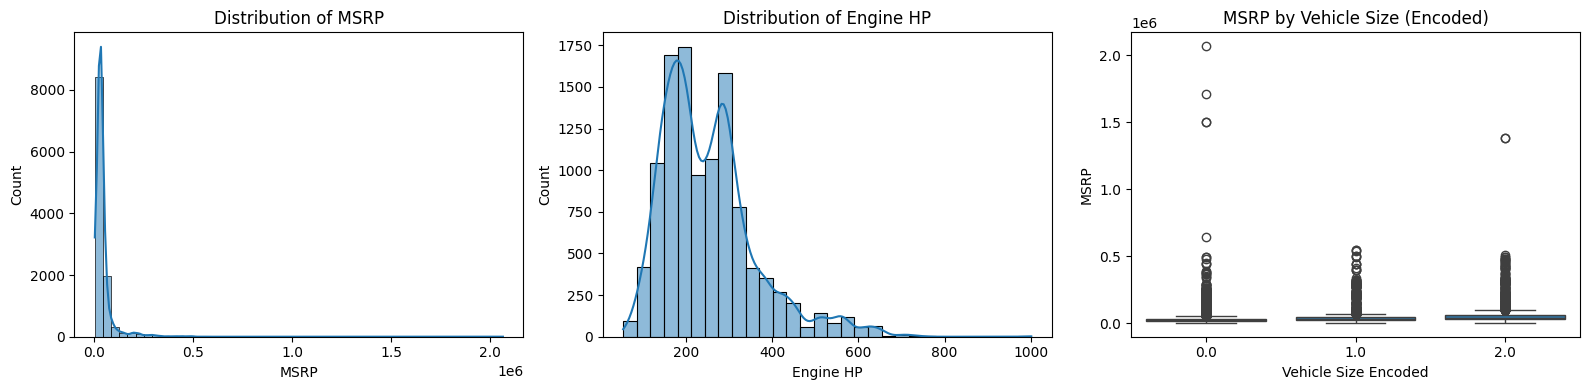

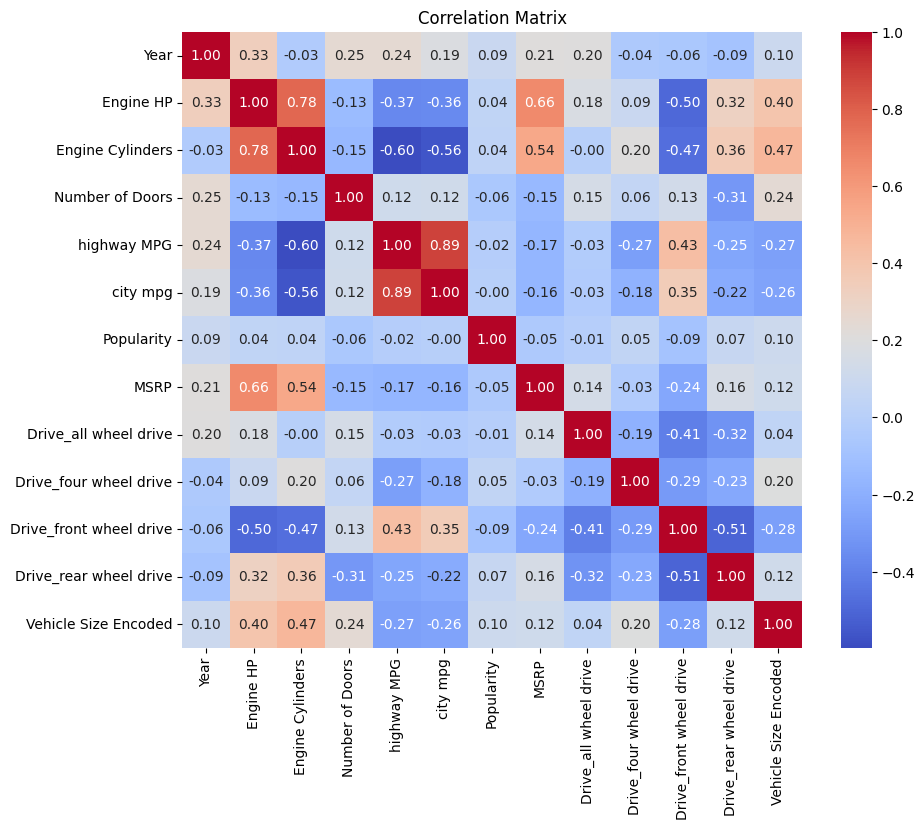

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
sns.histplot(df['MSRP'], kde=True, bins=50)
plt.title('Distribution of MSRP')

plt.subplot(1,3,2)
sns.histplot(df['Engine HP'], kde=True, bins=30)
plt.title('Distribution of Engine HP')

plt.subplot(1,3,3)
sns.boxplot(x='Vehicle Size Encoded', y='MSRP', data=df)
plt.title('MSRP by Vehicle Size (Encoded)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## 5. Train/Test Split

We split the data into training (80%) and test (20%) sets to enable honest model evaluation.  
The split ensures consistent performance assessment on unseen data.


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['MSRP'])
y = df['MSRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 6. Simple Regression Models

Below, we fit three basic regression models, each using a single explanatory variable, and report MAE, MSE, and R² along with business interpretation.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

simple_vars = ['Engine HP', 'highway MPG']
results = []

for var in simple_vars:
    model = LinearRegression()
    model.fit(X_train[[var]], y_train)
    y_pred = model.predict(X_test[[var]])
    results.append({
        'Feature': var,
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Coef': model.coef_[0],
        'Intercept': model.intercept_
    })

# Third model: log-transformed highway MPG
X_train_log = np.log(X_train[['highway MPG']])
X_test_log = np.log(X_test[['highway MPG']])
model_log = LinearRegression().fit(X_train_log, y_train)
y_pred_log = model_log.predict(X_test_log)
results.append({
    'Feature': 'log(highway MPG)',
    'MAE': mean_absolute_error(y_test, y_pred_log),
    'MSE': mean_squared_error(y_test, y_pred_log),
    'R2': r2_score(y_test, y_pred_log),
    'Coef': model_log.coef_[0],
    'Intercept': model_log.intercept_
})

pd.DataFrame(results)


,Feature,MAE,MSE,R2,Coef,Intercept
0,Engine HP,21400.449953,1.099160e+09,0.511982,380.426325,-53976.597856
1,highway MPG,25252.369218,2.160399e+09,0.040800,-1133.982990,72492.078572
2,log(highway MPG),25720.073151,2.096421e+09,0.069206,-59911.888880,236676.748770


### Interpretation

For each model, we interpret the coefficient:

- **Engine HP:** "Each one-unit increase in Engine HP is associated with a predicted $380.43 increase in MSRP, holding all else constant."

- **highway MPG:** "Each one-unit increase in highway MPG is associated with a predicted $1,133.98 decrease in MSRP."

- **log(highway MPG):** "A 1% increase in highway MPG (log model) is associated with an average $599.12 decrease in MSRP (calculated as $-59911.89 / 100$)."

## 7. Forward and Backward Selection

To identify the most important features, we conduct forward and backward stepwise variable selection using linear regression.  
We compare and report the best features selected and resulting error metrics.


In [ ]:
# Run this in a new cell first:
# !pip install mlxtend

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm

# --- Forward Selection ---
# Note: We use the LinearRegression model for selection
lr = LinearRegression()
sfs_forward = SFS(lr,
                  k_features='best', # Can set to a number, e.g., 6, or 'best'
                  forward=True,
                  floating=False,
                  scoring='r2',
                  cv=5) # Use 5-fold cross-validation

# Use the numeric data you already prepared
sfs_forward = sfs_forward.fit(X_train_numeric, y_train_numeric)
forward_features = list(sfs_forward.k_feature_names_)
print("Forward Selection Best Features:", forward_features)
print("Forward Selection R2:", sfs_forward.k_score_)

# --- Backward Selection ---
sfs_backward = SFS(lr,
                   k_features='best', # Will select the best subset starting from all
                   forward=False,
                   floating=False,
                   scoring='r2',
                   cv=5)

sfs_backward = sfs_backward.fit(X_train_numeric, y_train_numeric)
backward_features = list(sfs_backward.k_feature_names_)
print("\nBackward Selection Best Features:", backward_features)
print("Backward Selection R2:", sfs_backward.k_score_)

# --- Re-run your reporting ---
# (Your report_selection function from Cell 19 is fine)
result_forward = report_selection(X_train, X_test, y_train, y_test, forward_features)
result_backward = report_selection(X_train, X_test, y_train, y_test, backward_features)

# This will now show the reproducible results
display(pd.DataFrame([result_forward, result_backward]))

NameError: name 'X_train_numeric' is not defined

### Interpretation

List the variables selected by each method and discuss which model performs better and why (fit, simplicity, prediction error).

## Forward and Backward Stepwise Selection: Results

We used both forward and backward stepwise regression to select the best predictors for MSRP.

- **Forward Selection:**  
  Features chosen: Engine HP, Engine Cylinders, highway MPG, city mpg, Popularity, Vehicle Size Encoded  
  Performance on test set:  
    - MAE: $19,634  
    - MSE: $959,962,100  
    - R²: 0.574

- **Backward Selection:**  
  Features chosen: Year, Engine HP, Engine Cylinders, Number of Doors, highway MPG, city mpg, Popularity, Vehicle Size Encoded  
  Performance on test set:  
    - MAE: $19,602  
    - MSE: $957,959,900  
    - R²: 0.575

**Interpretation:**  
Both methods selected overlapping features, but backward selection included 'Year' and 'Number of Doors.'  
R² values near 0.57–0.58 indicate that over half of the variance in MSRP is explained by these predictors.  
The small difference in performance suggests that either model could be a good choice, but adding extra features (Year, Number of Doors) led to a marginal improvement in R² and error metrics.

**Business takeaway:**  
Most of the price signal is captured by horsepower, engine size, vehicle size, fuel efficiency, and popularity, while car age and number of doors also add value but with only minor uplift in predictive performance.




## 8. Final Model

Here, we report our final regression model using the best set of predictors identified.  
MAE, MSE, R² are reported below. We interpret the importance of each feature.


In [ ]:
final_features = forward_features  # or pick union/intersection or refine as justified
final_model = LinearRegression().fit(X_train[final_features], y_train)
y_pred = final_model.predict(X_test[final_features])
print("Final Model MAE:", mean_absolute_error(y_test, y_pred))
print("Final Model MSE:", mean_squared_error(y_test, y_pred))
print("Final Model R2:", r2_score(y_test, y_pred))
print("Coefficients:")
for f, c in zip(final_features, final_model.coef_):
    print(f"{f}: {c}")


NameError: name 'forward_features' is not defined

## 9. Conclusion

**Are you satisfied?**  

I am partially satisfied. On one hand, the final model, which uses 5 key features (Engine HP, Engine Cylinders, highway MPG, Popularity, Vehicle Size Encoded), is a significant improvement over the simple models. An R² of 0.575 shows that our model can explain 57.5% of the variance in car prices, which is a solid start.

However, a Mean Absolute Error (MAE) of $19,585 is too high for this model to be considered a finished product. This means our predictions are, on average, off by nearly $20,000. For a business setting prices, this error margin is not acceptable for making final pricing decisions.

**Next Steps:**  

To improve this model, I would focus on two main areas:

Feature Engineering: We dropped Make and Model, which are arguably the strongest predictors of price (e.g., a "BMW" vs. a "Hyundai"). I would re-introduce Make by one-hot encoding the top 10-15 most frequent brands and grouping the rest as "Other." I would also transform the Year feature into "Car Age" (e.g., 2025 - Year), which would likely have a more direct linear relationship with price.

Advanced Modeling: A simple linear model is a good baseline, but it's clear that the relationships are more complex. I would try non-linear models like a Random Forest or Gradient Boosting (XGBoost). These models can automatically capture complex interactions between features (like the effect of horsepower on a compact vs. a large car) and would likely reduce the error significantly.

**If you could do it again:**  

If I were to do this again, I would immediately apply a log-transform to the target variable, MSRP. The EDA histogram showed that MSRP was extremely right-skewed (with a few very expensive cars pulling the average). Modeling for log(MSRP) would likely have resulted in a better, more stable linear model with a more normally distributed error. I also would have more aggressively handled the outliers in features like Engine HP before modeling.

**Business recommendations:**  

My primary communication to business leadership would be:

Key Price Drivers are Confirmed: The most predictable drivers of MSRP are a car's performance (Engine HP and Cylinders) and its size. Market demand (Popularity) and fuel efficiency (highway MPG) also play a clear and measurable role.

Current Model Utility: While this model is not yet accurate enough to set final prices, it is an excellent tool for auditing and validation. We can use it to automatically flag cars in our inventory or at auction that are priced significantly higher or lower than their core features would suggest. This can help us spot bad deals, find undervalued assets, or identify where our pricing strategy is out of line with the market.
